In [10]:
%matplotlib inline

import os
import time
import random

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from IPython.display import clear_output

from vae import VAE
from loss import VAELoss, FocalLoss  # VAELoss should compute reconstruction + KL

# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_DIR = "vae_dataset"
BATCH_SIZE = 8
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4
IMAGE_SIZE = (80, 80)   # (height, width)
LATENT_SIZE = 32
FEATURE_SIZES = [64]
SEED = 42

# Reproducibility
torch.manual_seed(SEED)
random.seed(SEED)


In [11]:
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all images (flat structure, no subfolders).
            transform (callable, optional): Transform(s) to apply to each image.
        """
        self.root_dir = root_dir
        self.transform = transform
        extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
        self.image_paths = [
            os.path.join(root_dir, fname)
            for fname in os.listdir(root_dir)
            if fname.lower().endswith(extensions)
        ]
        if not self.image_paths:
            raise RuntimeError(f"No images found in {root_dir} with extensions {extensions}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define transforms: resize, grayscale, to tensor
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])


In [12]:
dataset = ImageFolderDataset(IMAGE_DIR, transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,      # Adjust as needed
    pin_memory=True
)

In [13]:
vae = VAE(
    input_shape= tuple([1] + list(IMAGE_SIZE)),
    latent_size=LATENT_SIZE,
    feature_sizes=FEATURE_SIZES
).to(DEVICE)

criterion = VAELoss()
optimizer = torch.optim.AdamW(vae.parameters(), lr=LEARNING_RATE)


In [14]:
def plot_reconstructions(model, dataloader, epoch):
    """
    Draws a small grid of original vs. reconstructed images from one batch.
    Clears previous output to show updated plots inline.
    """
    model.eval()
    with torch.no_grad():
        images = next(iter(dataloader)).to(DEVICE)
        recon_images, _, _ = model(images)

        images_np  = images.cpu().numpy()
        recon_np   = recon_images.cpu().numpy()
        num_display = min(4, images_np.shape[0])

        # Clear previous output before plotting
        clear_output(wait=True)
        fig, axes = plt.subplots(2, num_display, figsize=(num_display * 2.5, 5))

        for i in range(num_display):
            # Original
            axes[0, i].imshow(images_np[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title("Original")

            # Reconstruction
            axes[1, i].imshow(recon_np[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title("Reconstructed")

        plt.suptitle(f"Epoch {epoch} Reconstructions", fontsize=14)
        plt.show()
    model.train()


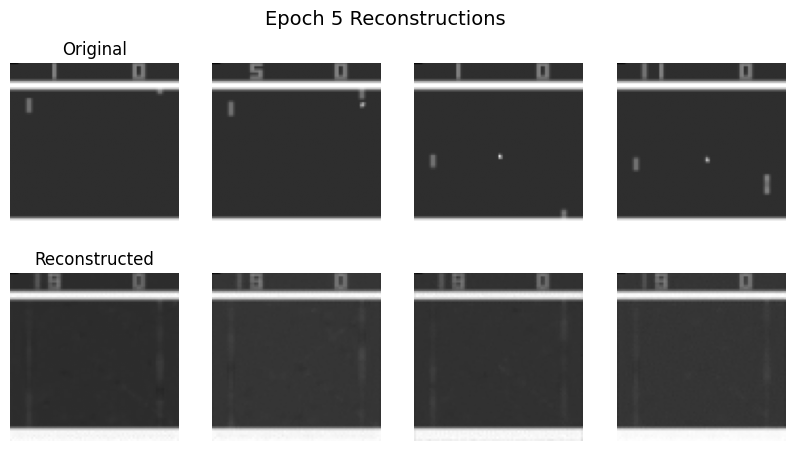

Saved model checkpoint: vae_checkpoint_epoch005.pt
Training complete. Final model saved to vae_final_model.pt


In [15]:
for epoch in range(1, NUM_EPOCHS + 1):
    vae.train()
    running_loss = 0.0

    for batch_idx, images in enumerate(dataloader, start=1):
        images = images.to(DEVICE)

        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss_value, recon_loss, kl_loss  = criterion(recon_images, images, mu, logvar)
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()

        # Every 100 batches, print the average loss so far in this epoch
        if batch_idx % 100 == 0:
            avg_loss = running_loss / 100
            print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] "
                  f"Epoch [{epoch}/{NUM_EPOCHS}] "
                  f"Batch [{batch_idx}/{len(dataloader)}] "
                  f"Loss: {avg_loss:.6f}")
            running_loss = 0.0

    # After each epoch, plot reconstructions inline
    plot_reconstructions(vae, dataloader, epoch)

    # Optionally, save intermediate checkpoints
    if epoch % 5 == 0 or epoch == NUM_EPOCHS:
        ckpt_path = f"vae_checkpoint_epoch{epoch:03d}.pt"
        torch.save(vae.state_dict(), ckpt_path)
        print(f"Saved model checkpoint: {ckpt_path}")

# Save final model weights
torch.save(vae.state_dict(), "vae_final_model.pt")
print("Training complete. Final model saved to vae_final_model.pt")
